In [1]:
import cv2
import mediapipe as mp
import numpy as np
#import time
import pandas as pd
import os
import matplotlib.pyplot as plt
#import random
from PIL import Image
#import shutil
import tensorflow as tf
#from tensorflow import keras, io, image, 
import tensorflow_hub as hub
from cv2 import imshow
# from tensorflow.keras import models, layers
# from tensorflow.keras.applications import efficientnet
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import image_dataset_from_directory
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import utils, optimizers
# from tensorflow_docs.vis import embed
from math import atan2, degrees, fabs
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import imageio
from IPython.display import HTML, display

2023-03-15 12:36:59.409292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 12:37:00.456940: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/.pyenv/versions/3.10.6/envs/yogi/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-15 12:37:00.456971: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 12:37:03.489128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libn

In [2]:
root_dir = '../raw_data/YOGI_Ground_Truths_new'
path = root_dir
img_height, img_width = 128, 128
batch_size = 32
poses_list = os.listdir(root_dir) #Lists all folders in the root directory (raw_data folder)
poses_list

['Happy_Baby_Pose_or_Ananda_Balasana_.jpeg',
 'Four-Limbed_Staff.jpeg',
 'Plank_Pose_or_Kumbhakasana_.jpeg',
 'Boat_Pose_or_Paripurna_Navasana_.jpeg',
 'Upward_facing_dog_urdhva_mukha_svanasana.jpg',
 'Lotus_pose_padmasana.jpeg',
 'Pigeon_Pose_or_Kapotasana_.jpeg',
 'Camel_Pose_or_Ustrasana_.jpeg',
 'Cow_Face_Pose_or_Gomukhasana_.jpeg',
 'Pose_Dedicated_to_the_Sage_Koundinya_or_Eka_Pada_Koundinyanasana_I_and_II.jpeg',
 'Split_pose.jpeg',
 'Intense_Side_Stretch_Pose_or_Parsvottanasana_.jpeg',
 'Gate_Pose_or_Parighasana_.jpeg',
 'Warrior_I_Pose_or_Virabhadrasana_I_.jpeg',
 'Sitting_pose_1_(normal).jpeg',
 'Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_Twist.jpeg',
 'Peacock_Pose_or_Mayurasana_.png',
 'Legs-Up-the-Wall_Pose_or_Viparita_Karani_.jpeg',
 'Supta_Baddha_Konasana_.jpeg',
 'Shoulder-Pressing_Pose_or_Bhujapidasana_.jpg',
 'Side-Reclining_Leg_Lift_pose_or_Anantasana_.jpeg',
 'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_.jpeg',
 'Frog_Pose_or_Bhekasana.jpeg

Movenet

In [4]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [6]:
def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [7]:
model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

2023-03-15 12:37:38.982872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 12:37:38.990358: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/.pyenv/versions/3.10.6/envs/yogi/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-15 12:37:38.990477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/.pyenv/versions/3.10.6/envs/yogi/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-15 12:37:38.990543: W tensorflow/compiler/xla/stream_executor/plat

Run Inference on Single Images

In [60]:
# Load the input image.
image_path = root_dir + '/' + 'Boat_Pose_or_Paripurna_Navasana_.jpeg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
image.shape

TensorShape([1350, 2400, 3])

In [63]:
height = image.shape[0]
width = image.shape[1]
print(height)
print(width)

1350
2400


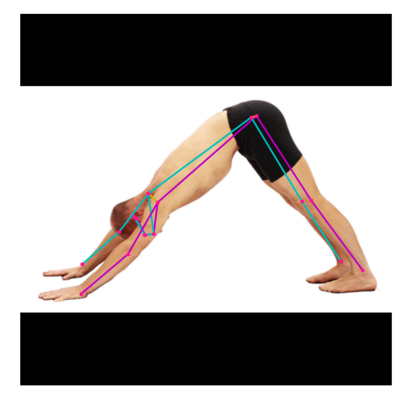

In [39]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [ ]:
keypoints_with_scores

In [50]:
key_xy = keypoints_with_scores[:, :, :, :2]

# Create a dictionary of keypoints and their corresponding vector tuples
key_dict = {}
for key, value in KEYPOINT_DICT.items():
    vector = tuple(key_xy[0, 0, value])
    key_dict[key] = vector
    
print(key_dict)

{'nose': (0.59237236, 0.359208), 'left_eye': (0.59502167, 0.33636254), 'right_eye': (0.5944384, 0.33456403), 'left_ear': (0.55033314, 0.31305045), 'right_ear': (0.54558283, 0.30628657), 'left_shoulder': (0.5072211, 0.3699215), 'right_shoulder': (0.48332757, 0.34505588), 'left_elbow': (0.6467128, 0.28991154), 'right_elbow': (0.5864773, 0.2663042), 'left_wrist': (0.75365496, 0.16370451), 'right_wrist': (0.67375827, 0.16670614), 'left_hip': (0.274216, 0.6360346), 'right_hip': (0.2781858, 0.62190914), 'left_knee': (0.50197387, 0.7834004), 'right_knee': (0.50413144, 0.75816214), 'left_ankle': (0.68954825, 0.9216374), 'right_ankle': (0.66598266, 0.8629383)}


# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

In [51]:
angles_dictionary = {
    "left_elbow_a": (key_dict["left_wrist"],key_dict["left_elbow"],key_dict["left_shoulder"]),
    "right_elbow_a": (key_dict["right_wrist"],key_dict["right_elbow"],key_dict["right_shoulder"]),
    "left_shoulder_b": (key_dict["left_elbow"],key_dict["left_shoulder"],key_dict["left_hip"]),
    "left_shoulder_a": (key_dict["left_hip"],key_dict["left_shoulder"],key_dict["right_shoulder"]), 
    "right_shoulder_b": (key_dict["right_elbow"],key_dict["right_shoulder"],key_dict[ "right_hip"]), 
    "right_shoulder_a": (key_dict["right_hip"],key_dict["right_shoulder"],key_dict[ "left_shoulder"]), 
    "left_hip_a": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "right_hip"]), 
    "left_hip_b": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "left_knee"]),
    "left_hip_c": (key_dict["right_hip"],key_dict["left_hip"],key_dict[ "left_knee"]),
    "right_hip_a": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "left_hip"]), 
    "right_hip_b": (key_dict["left_hip"],key_dict["right_hip"],key_dict[ "right_knee"]),
    "right_hip_c": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "right_knee"]),
    "left_knee_a": (key_dict["left_hip"],key_dict["left_knee"],key_dict[ "left_ankle"]),
    "right_knee_a": (key_dict["right_hip"],key_dict["right_knee"],key_dict[ "right_ankle"])
} 

In [ ]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [ ]:
angles = {}
for key, value in angles_dictionary.items():
    angle = calculate_angle(value[0], value[1], value[2])
    angles[key] = angle

print(angles)

2023-03-15 11:36:22.279435: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19660800 exceeds 10% of free system memory.
/tmp/ipykernel_32288/2525846559.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
/tmp/ipykernel_32288/3893998143.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))
2023-03-15 11:38:11.069327: W tensorflow/core/framework/op_kernel.cc:1

InvalidArgumentError: Graph execution error:

input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]] [Op:__inference_signature_wrapper_571172]

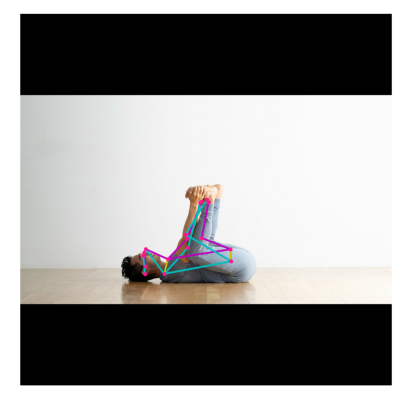

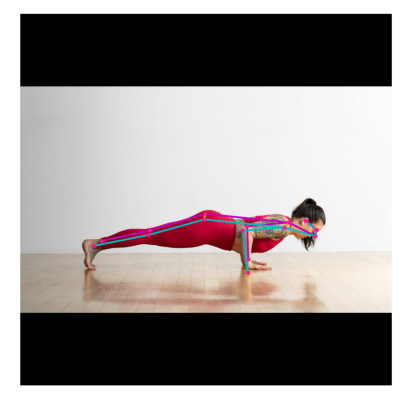

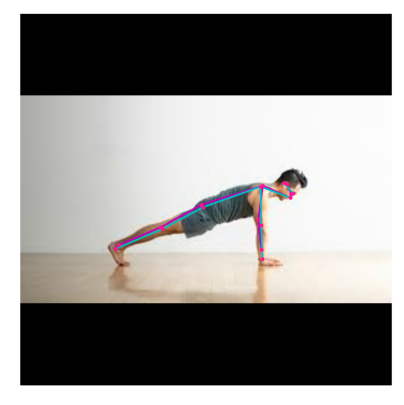

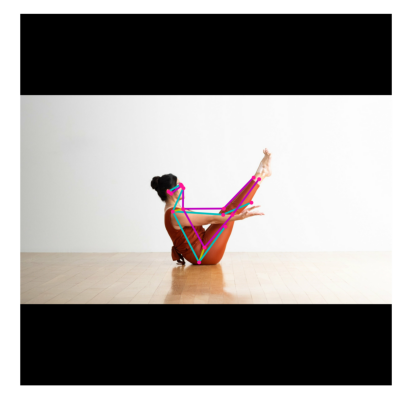

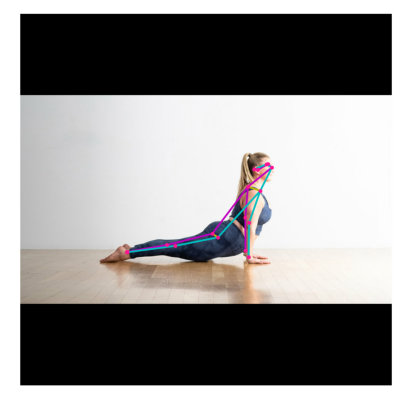

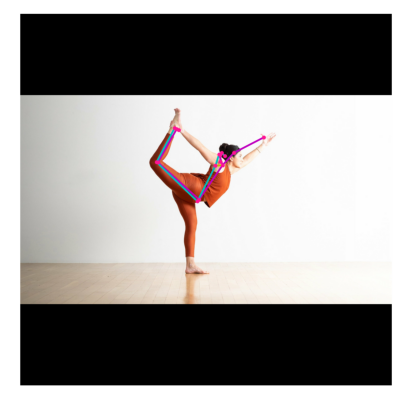

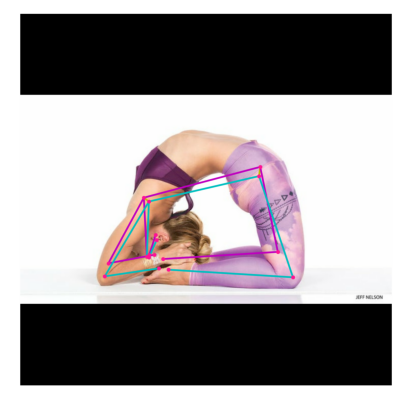

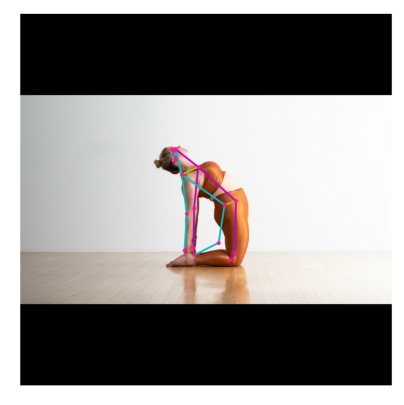

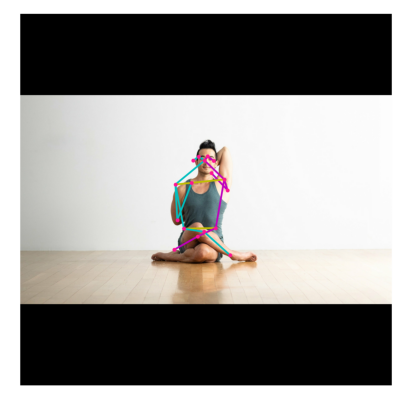

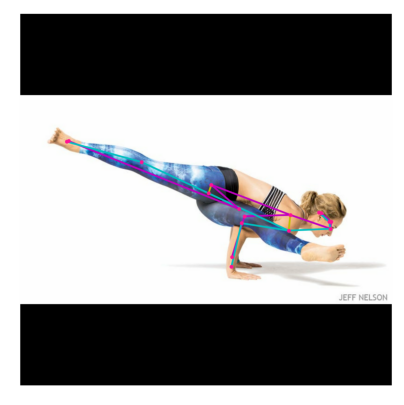

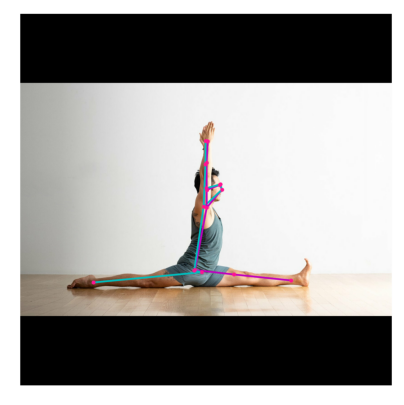

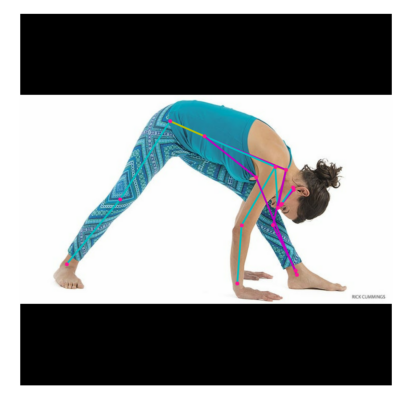

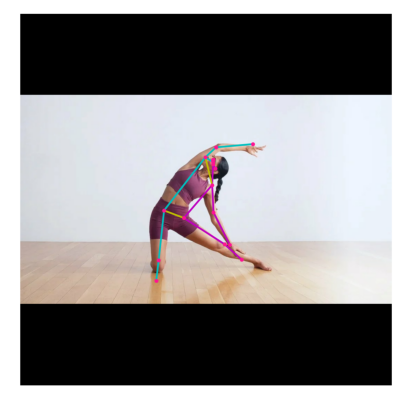

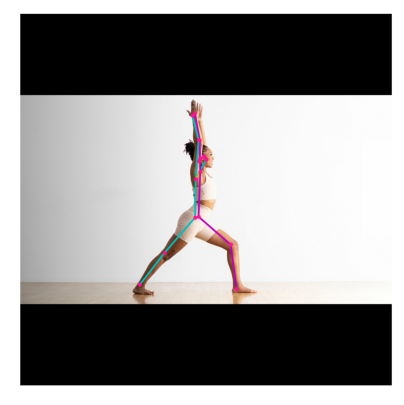

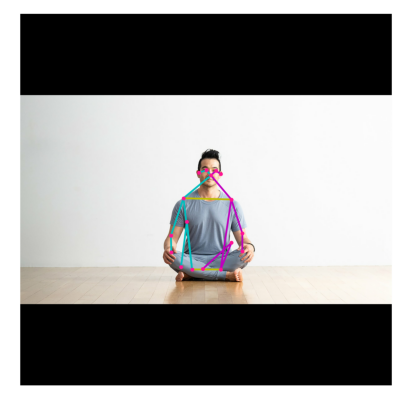

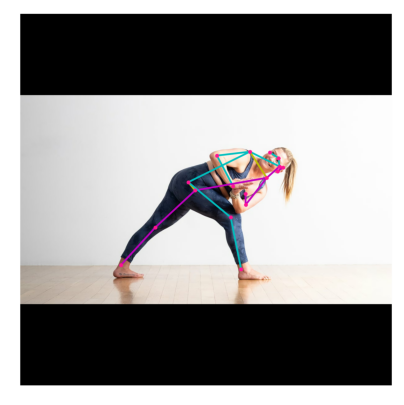

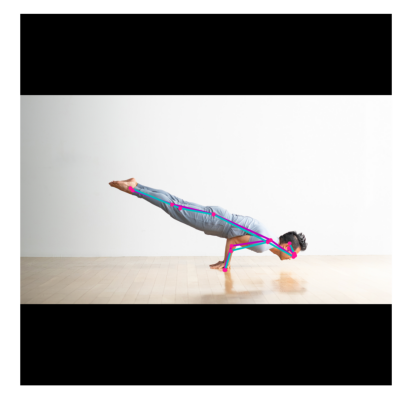

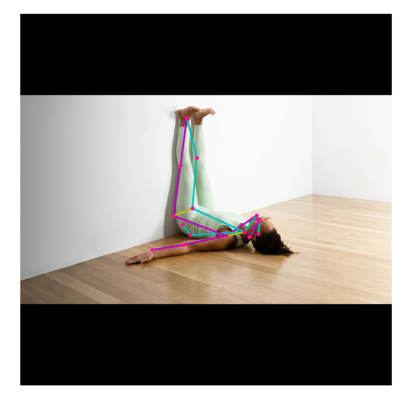

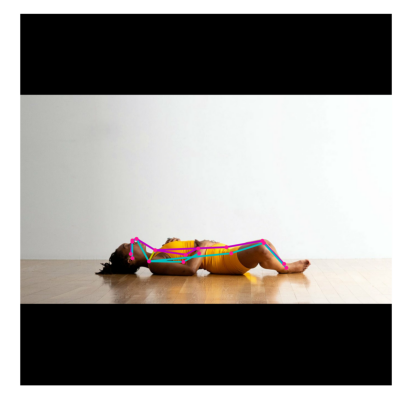

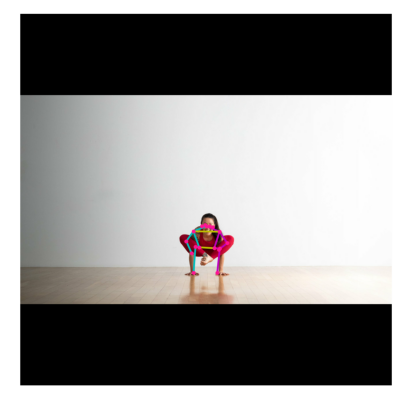

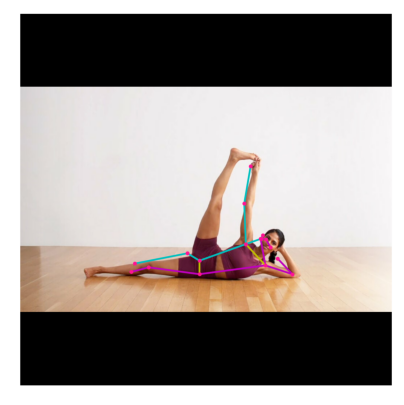

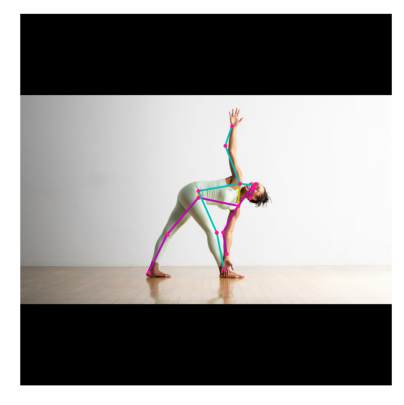

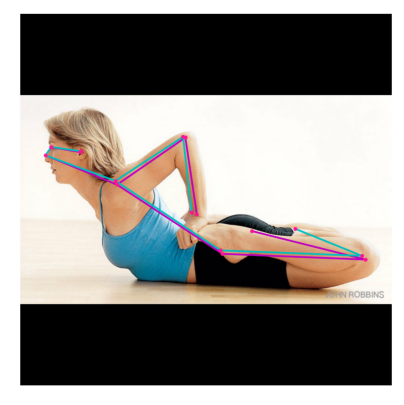

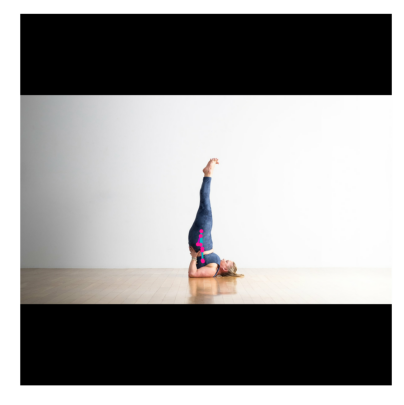

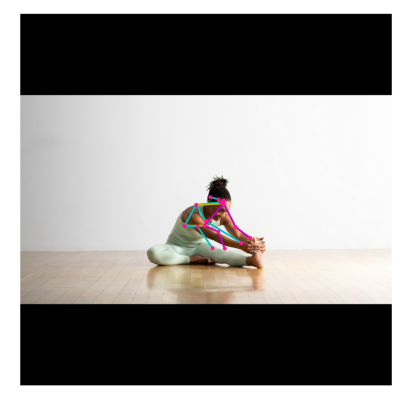

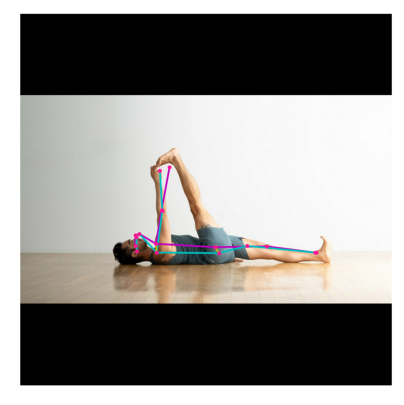

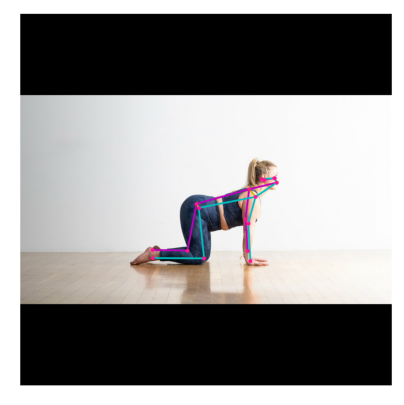

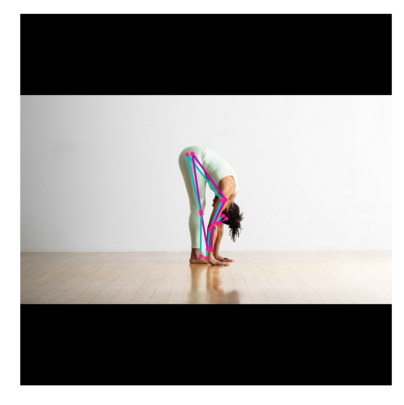

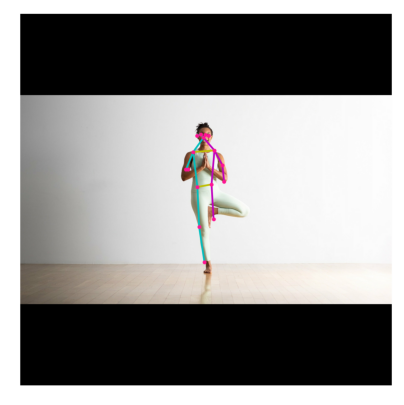

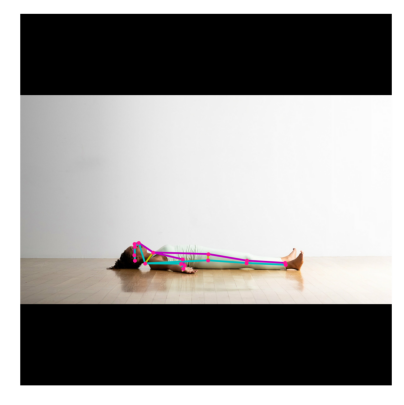

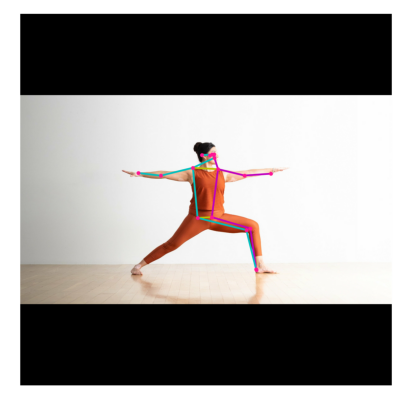

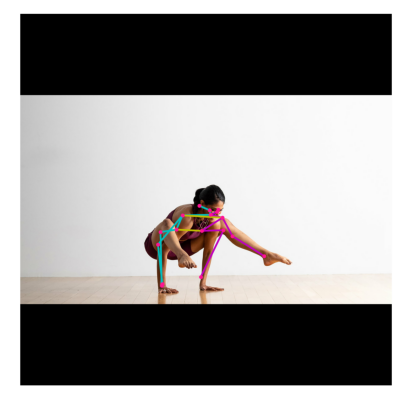

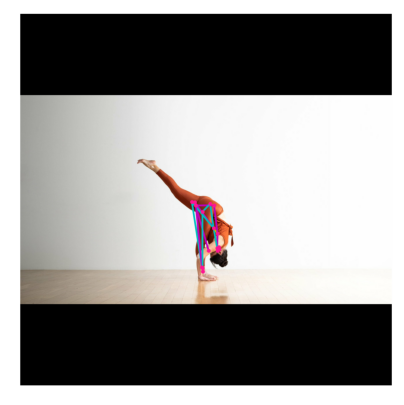

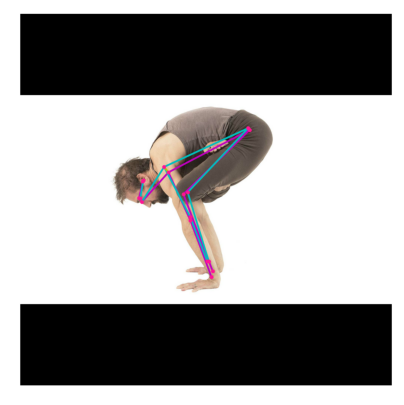

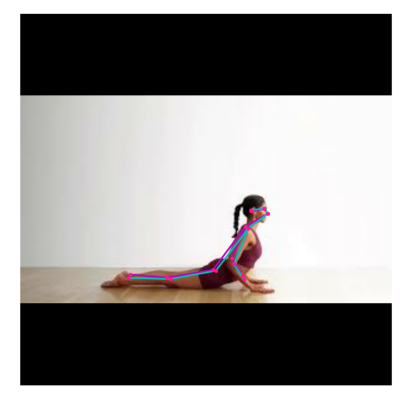

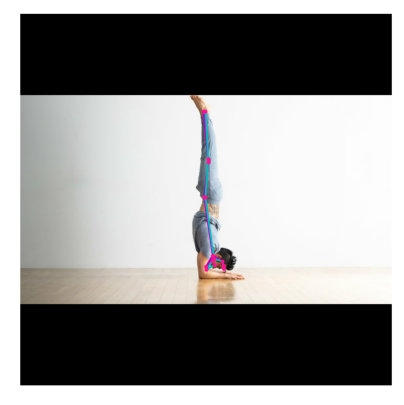

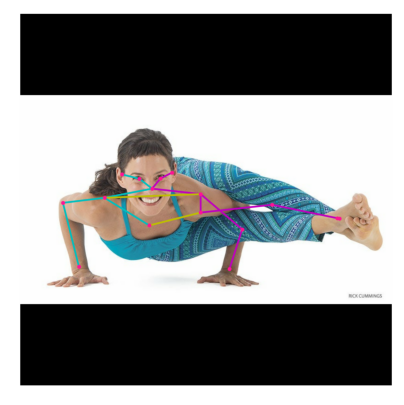

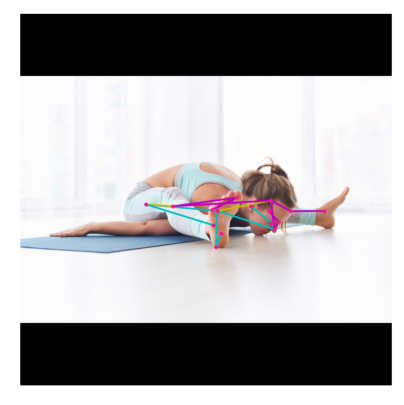

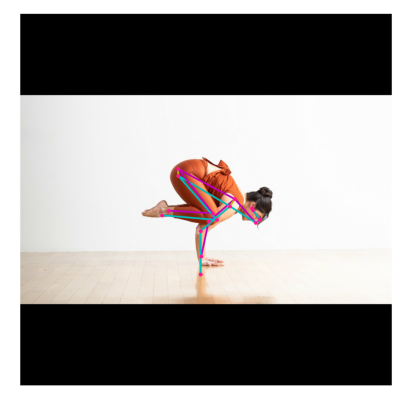

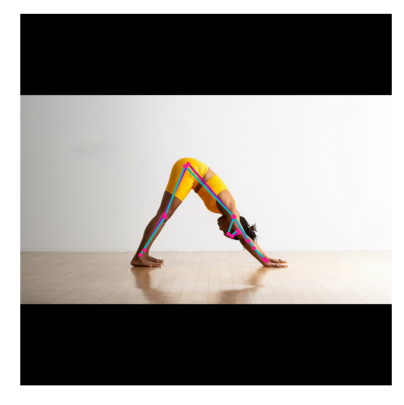

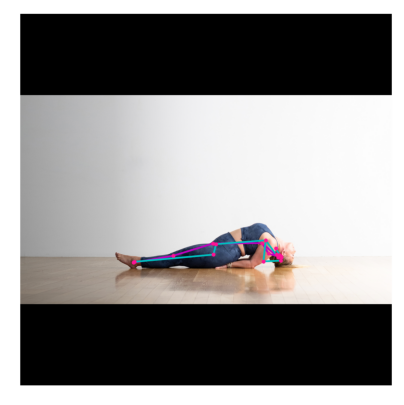

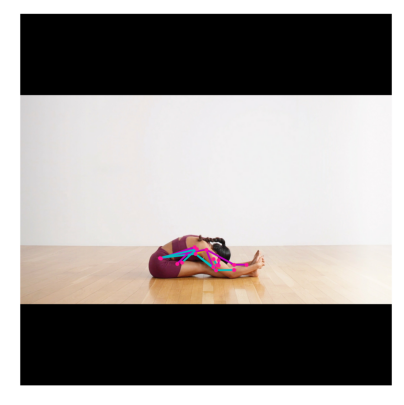

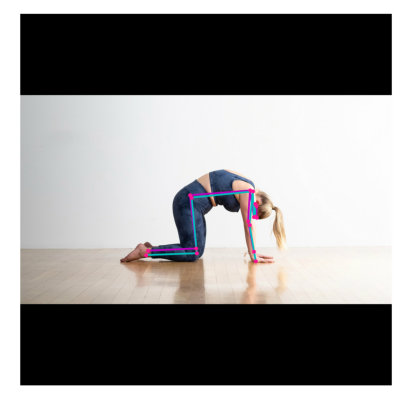

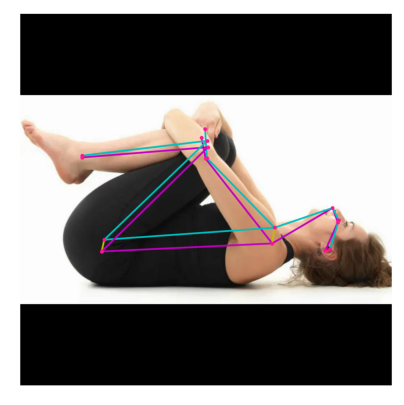

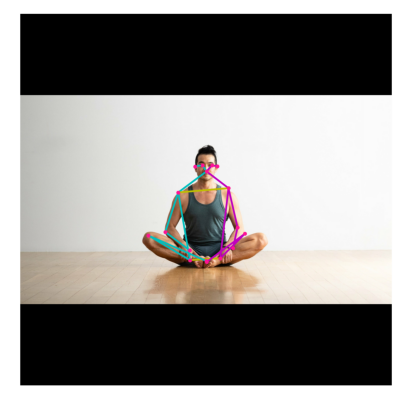

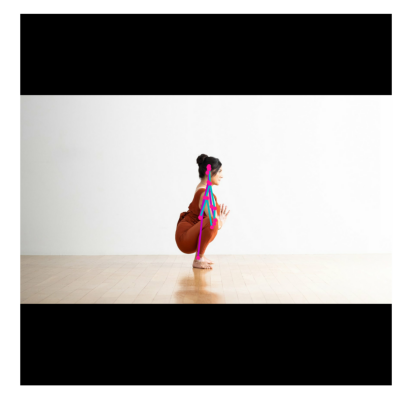

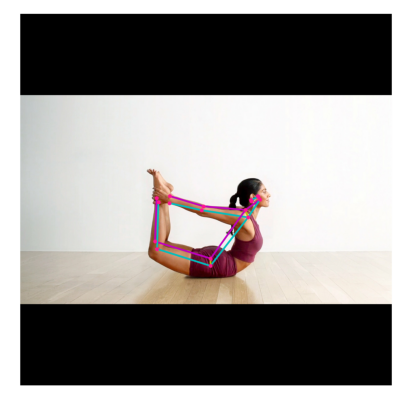

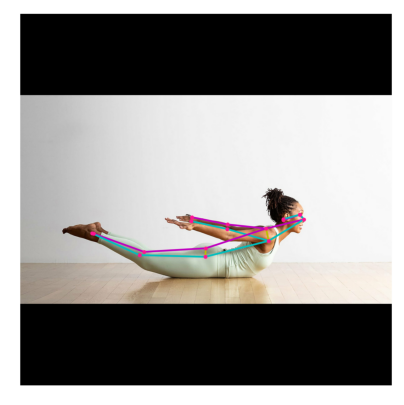

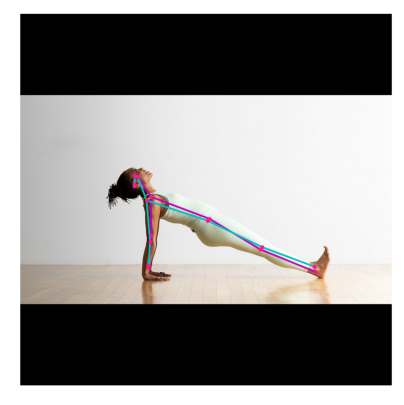

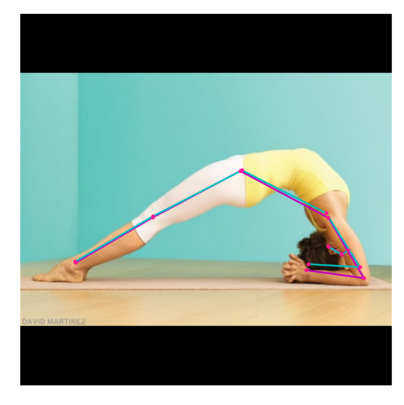

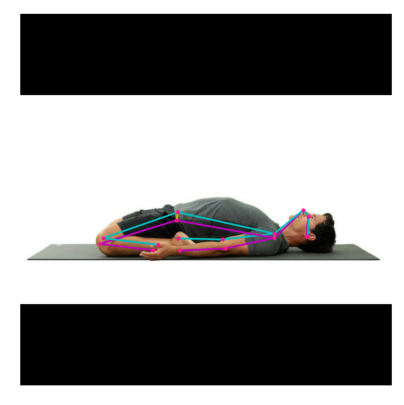

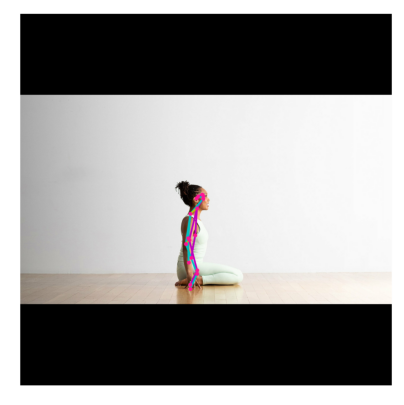

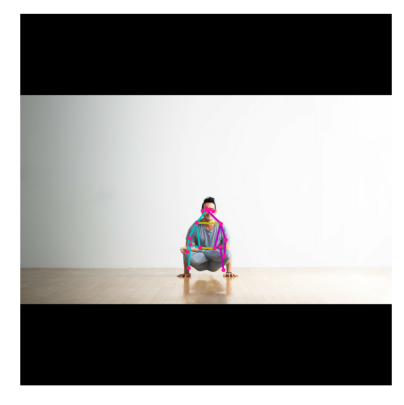

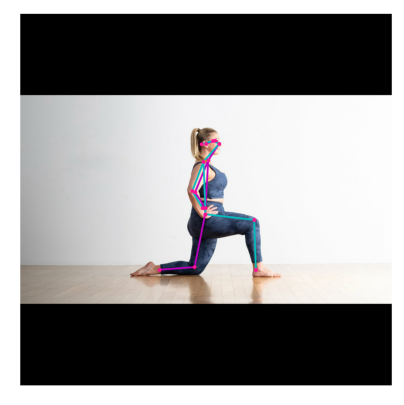

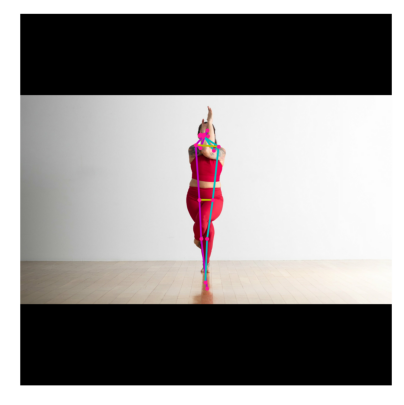

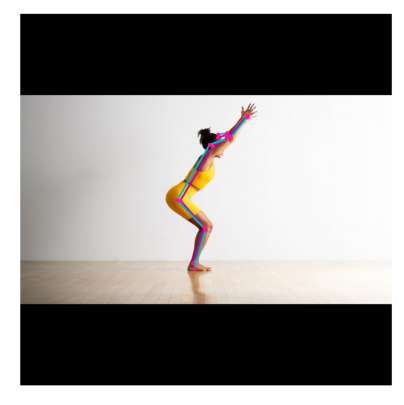

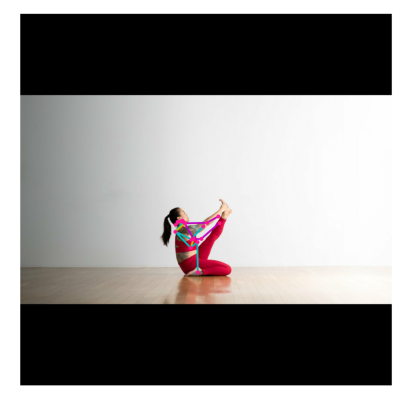

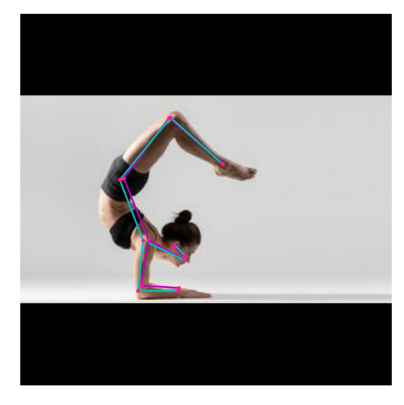

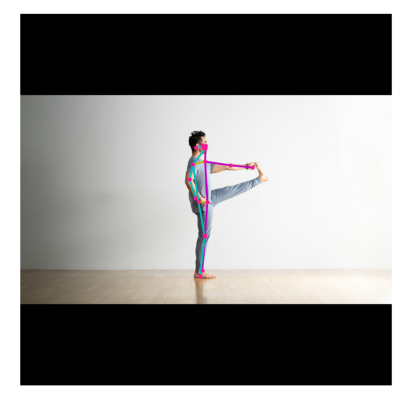

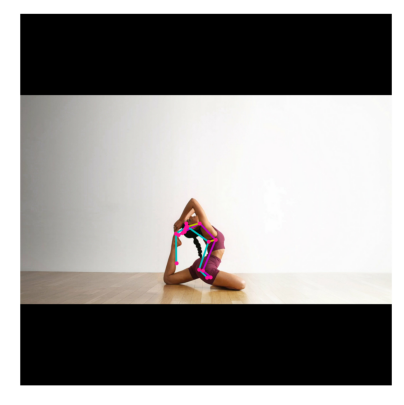

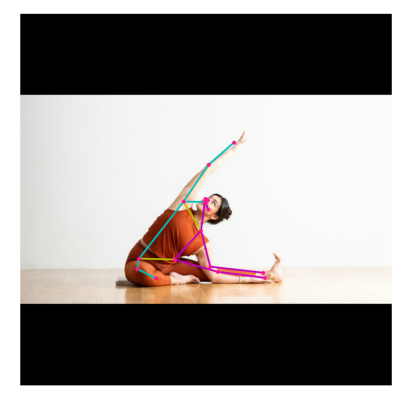

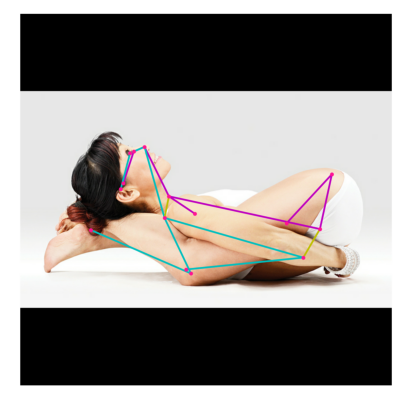

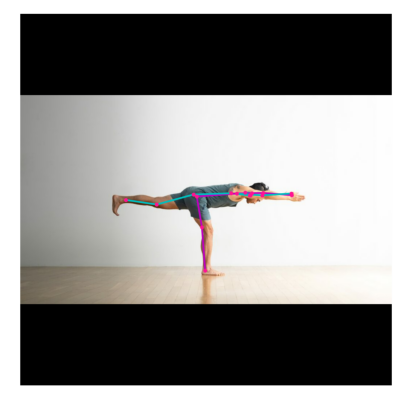

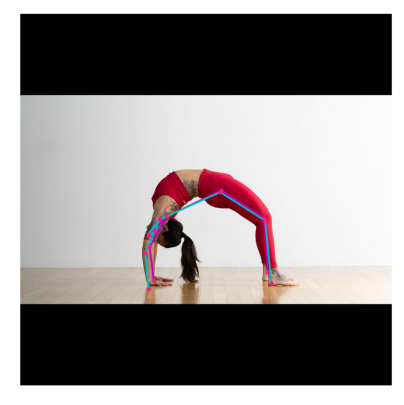

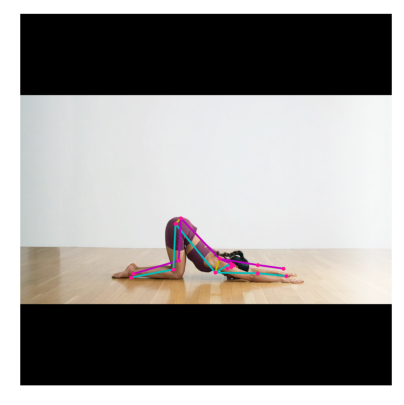

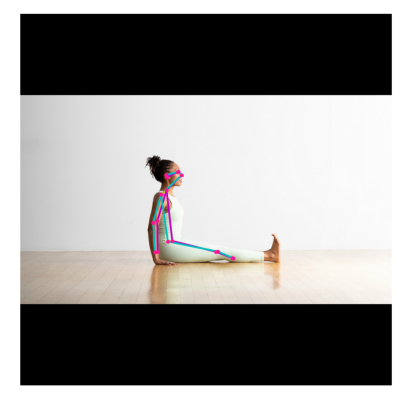

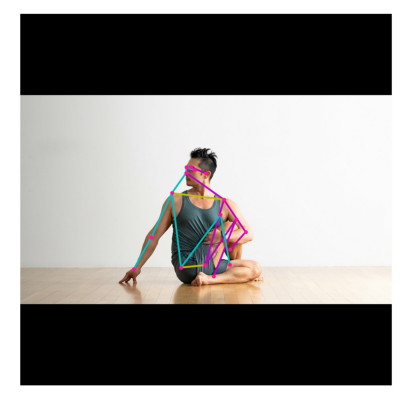

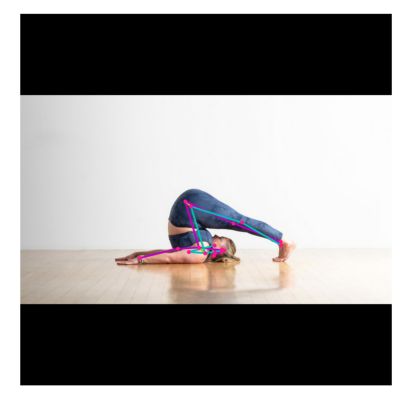

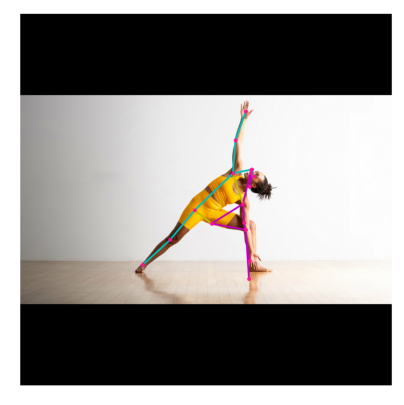

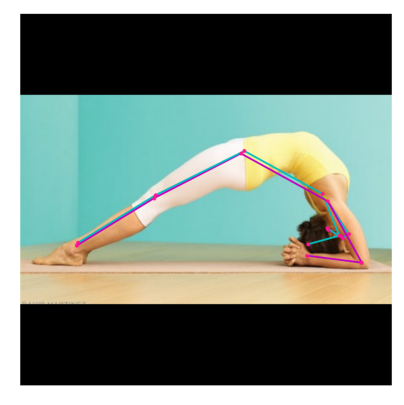

: 

In [64]:
for img in os.listdir(path):
    # Load the input image.
    image_path = path + '/' + img
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(output_overlay)
    _ = plt.axis('off')
    
    # fname = 'raw_data/Ground_truth_Pose_Defined/{}'.format(img)
    # plt.savefig(fname)
    # print('Saving', img, 'to', fname)
   

Calculate Angles

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}



In [63]:
all_poses = {}

for img in os.listdir(path):
    # Load the input image.
    image_path = path + '/' + img
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    # # Visualize the predictions with image.
    # display_image = tf.expand_dims(image, axis=0)
    # display_image = tf.cast(tf.image.resize_with_pad(
    #     display_image, 1280, 1280), dtype=tf.int32)
    # output_overlay = draw_prediction_on_image(
    #     np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
         
    key_xy = keypoints_with_scores[:, :, :, :2]

    # Create a dictionary of keypoints and their corresponding vector tuples
    key_dict = {}
    for key, value in KEYPOINT_DICT.items():
        vector = tuple(key_xy[0, 0, value])
        key_dict[key] = vector
        
    #print(key_dict)
    pose_name = f"{img.strip('.jpeg')}"
    
    angles_dictionary = {
            "left_elbow_a": (key_dict["left_wrist"],key_dict["left_elbow"],key_dict["left_shoulder"]),
            "right_elbow_a": (key_dict["right_wrist"],key_dict["right_elbow"],key_dict["right_shoulder"]),
            "left_shoulder_b": (key_dict["left_elbow"],key_dict["left_shoulder"],key_dict["left_hip"]),
            "left_shoulder_a": (key_dict["left_hip"],key_dict["left_shoulder"],key_dict["right_shoulder"]), 
            "right_shoulder_b": (key_dict["right_elbow"],key_dict["right_shoulder"],key_dict[ "right_hip"]), 
            "right_shoulder_a": (key_dict["right_hip"],key_dict["right_shoulder"],key_dict[ "left_shoulder"]), 
            "left_hip_a": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "right_hip"]), 
            "left_hip_b": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "left_knee"]),
            "left_hip_c": (key_dict["right_hip"],key_dict["left_hip"],key_dict[ "left_knee"]),
            "right_hip_a": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "left_hip"]), 
            "right_hip_b": (key_dict["left_hip"],key_dict["right_hip"],key_dict[ "right_knee"]),
            "right_hip_c": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "right_knee"]),
            "left_knee_a": (key_dict["left_hip"],key_dict["left_knee"],key_dict[ "left_ankle"]),
            "right_knee_a": (key_dict["right_hip"],key_dict["right_knee"],key_dict[ "right_ankle"])
        }  
    
    angles = {}    
    # pose_name = {}
    for key, value in angles_dictionary.items():
        angle = calculate_angle(value[0], value[1], value[2])
        angles[key] = angle
        all_poses[pose_name] = angles
    print(pose_name)
    print(angles)
  
print(all_poses)  

NameError: name 'calculate_angle' is not defined

In [ ]:
all_poses

In [ ]:
import json

# with open('data.json', 'wb') as fp:
#     pickle.dump(all_poses, fp)

# with open('data.json', 'rb') as fp:
#     data = pickle.dump(fp)
# print(data)
# print(type(data))

with open('data.json', 'w') as fp:
    json.dump(all_poses, fp)

In [8]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [14]:
# Conversion of JSON data to
# dictionary
import json
 
# Opening JSON file
with open('data.json') as json_file:
    data = json.load(json_file)
 
    # Print the type of data variable
    print("Type:", type(data))
 
    # Print the data of dictionary
    ground_pose_dict = data

print(ground_pose_dict)

Type: <class 'dict'>
{'Happy_Baby_Pose_or_Ananda_Balasana_': {'left_elbow_a': 157.69640840733888, 'right_elbow_a': 153.004464598512, 'left_shoulder_b': 37.65210081861229, 'left_shoulder_a': 112.05816673092605, 'right_shoulder_b': 37.17437689749409, 'right_shoulder_a': 66.1731334716988, 'left_hip_a': 84.45707859677022, 'left_hip_b': 30.285065610025708, 'left_hip_c': 114.74213737660675, 'right_hip_a': 97.31161755813926, 'right_hip_b': 56.21831717151281, 'right_hip_c': 41.09330038662645, 'left_knee_a': 100.82193181036479, 'right_knee_a': 89.00655831988898}, 'Four-Limbed_Staff': {'left_elbow_a': 93.09485684005932, 'right_elbow_a': 87.22644026745441, 'left_shoulder_b': 11.157120839404998, 'left_shoulder_a': 54.75534529280944, 'right_shoulder_b': 10.102061518313128, 'right_shoulder_a': 125.43261650419296, 'left_hip_a': 94.78233020659185, 'left_hip_b': 157.4395076898107, 'left_hip_c': 62.65717748321885, 'right_hip_a': 85.02972165678408, 'right_hip_b': 116.2607106376197, 'right_hip_c': 158.709

In [41]:
def angle_calc(image):  #(image_capture)
    
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    key_xy = keypoints_with_scores[:, :, :, :2]                                             

    # Create a dictionary of keypoints and their corresponding vector tuples
    key_dict = {}
    for key, value in KEYPOINT_DICT.items():
        vector = tuple(key_xy[0, 0, value])
        key_dict[key] = vector
  
    def calculate_angle(a,b,c):
        a = np.array(a) # First
        b = np.array(b) # Mid
        c = np.array(c) # End
        
        radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
        angle = np.abs(radians*180.0/np.pi)
        
        if angle >180.0:
            angle = 360-angle
            
        return angle 

    # make angles_dictionary
    angles_dictionary = {
    "left_elbow_a": (key_dict["left_wrist"],key_dict["left_elbow"],key_dict["left_shoulder"]),
    "right_elbow_a": (key_dict["right_wrist"],key_dict["right_elbow"],key_dict["right_shoulder"]),
    "left_shoulder_b": (key_dict["left_elbow"],key_dict["left_shoulder"],key_dict["left_hip"]),
    "left_shoulder_a": (key_dict["left_hip"],key_dict["left_shoulder"],key_dict["right_shoulder"]),
    "right_shoulder_b": (key_dict["right_elbow"],key_dict["right_shoulder"],key_dict[ "right_hip"]),
    "right_shoulder_a": (key_dict["right_hip"],key_dict["right_shoulder"],key_dict[ "left_shoulder"]),
    "left_hip_a": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "right_hip"]),
    "left_hip_b": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "left_knee"]),
    "left_hip_c": (key_dict["right_hip"],key_dict["left_hip"],key_dict[ "left_knee"]),
    "right_hip_a": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "left_hip"]),
    "right_hip_b": (key_dict["left_hip"],key_dict["right_hip"],key_dict[ "right_knee"]),
    "right_hip_c": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "right_knee"]),
    "left_knee_a": (key_dict["left_hip"],key_dict["left_knee"],key_dict[ "left_ankle"]),
    "right_knee_a": (key_dict["right_hip"],key_dict["right_knee"],key_dict[ "right_ankle"])
    }

    angles = {}

    for key, value in angles_dictionary.items():
        angle = calculate_angle(value[0], value[1], value[2])
        angles[key] = angle

    return(angles)

In [42]:
Downward_Facing_Dog_pose_or_Adho_Mukha_Svanasana_m = {
    "left_elbow_a": 1,
    "right_elbow_a": 1,
    "left_shoulder_b": 1,
    "left_shoulder_a": 0,
    "right_shoulder_b": 1,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 0,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 0,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

Tree_Pose_or_Vrksasana_m = {
    "left_elbow_a": 0,
    "right_elbow_a": 0,
    "left_shoulder_b": 0,
    "left_shoulder_a": 0,
    "right_shoulder_b": 0,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 0,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 0,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

Warrior_I_Pose_or_Virabhadrasana_I_m = {
    "left_elbow_a": 1,
    "right_elbow_a": 1,
    "left_shoulder_b": 1,
    "left_shoulder_a": 0,
    "right_shoulder_b": 1,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 0,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 0,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

Warrior_II_Pose_or_Virabhadrasana_II_m = {
     "left_elbow_a": 1,
    "right_elbow_a": 1,
    "left_shoulder_b": 1,
    "left_shoulder_a": 0,
    "right_shoulder_b": 1,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 1,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 1,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

Warrior_III_Pose_or_Virabhadrasana_III_m = {
    "left_elbow_a": 1,
    "right_elbow_a": 1,
    "left_shoulder_b": 1,
    "left_shoulder_a": 0,
    "right_shoulder_b": 1,
    "right_shoulder_a": 0,
    "left_hip_a": 0,
    "left_hip_b": 1,
    "left_hip_c": 0,
    "right_hip_a": 0,
    "right_hip_b": 1,
    "right_hip_c": 0,
    "left_knee_a": 1,
    "right_knee_a": 1,
}

In [43]:
dict1 = ground_pose_dict['Downward_Facing_Dog_pose_or_Adho_Mukha_Svanasana_']
dict2 = angle_calc(image)
      
print(dict1)
print(dict2)

{'left_elbow_a': 169.28172063600115, 'right_elbow_a': 166.38449099386514, 'left_shoulder_b': 169.7411701586239, 'left_shoulder_a': 178.89639670324402, 'right_shoulder_b': 168.3199307357493, 'right_shoulder_a': 4.330094046977964, 'left_hip_a': 96.40139922858668, 'left_hip_b': 65.77020012199225, 'left_hip_c': 30.631199106594444, 'right_hip_a': 80.37210637872566, 'right_hip_b': 145.6031586883938, 'right_hip_c': 65.2310591398573, 'left_knee_a': 175.63121475260675, 'right_knee_a': 168.30729852825047}
{'left_elbow_a': 160.11426805276673, 'right_elbow_a': 168.5897678315655, 'left_shoulder_b': 161.04277398645092, 'left_shoulder_a': 94.93718789792007, 'right_shoulder_b': 163.8982165312448, 'right_shoulder_a': 80.39543830493042, 'left_hip_a': 25.507488304479775, 'left_hip_b': 81.69904820991906, 'left_hip_c': 107.20653992949342, 'right_hip_a': 159.15989573795352, 'right_hip_b': 74.60604702102256, 'right_hip_c': 84.55384871693094, 'left_knee_a': 176.51484998590965, 'right_knee_a': 178.173984897575

In [44]:
#from yogi.angle_calc import *
#def angle_comp(position,array)
# Load the input image.
img_dir = '../images'
image_path = img_dir + '/' + 'test_downward.png'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

dict1 = ground_pose_dict['Downward_Facing_Dog_pose_or_Adho_Mukha_Svanasana_']
dict2 = angle_calc(image)
dict3 = {}
dict4 = Downward_Facing_Dog_pose_or_Adho_Mukha_Svanasana_m

for dict1_key, dict1_values in dict1.items():
    dict3[dict1_key] = abs(dict2[dict1_key]-dict1[dict1_key]) * dict4[dict1_key]
      
print(dict1)
print(dict2)
print(dict3)


{'left_elbow_a': 169.28172063600115, 'right_elbow_a': 166.38449099386514, 'left_shoulder_b': 169.7411701586239, 'left_shoulder_a': 178.89639670324402, 'right_shoulder_b': 168.3199307357493, 'right_shoulder_a': 4.330094046977964, 'left_hip_a': 96.40139922858668, 'left_hip_b': 65.77020012199225, 'left_hip_c': 30.631199106594444, 'right_hip_a': 80.37210637872566, 'right_hip_b': 145.6031586883938, 'right_hip_c': 65.2310591398573, 'left_knee_a': 175.63121475260675, 'right_knee_a': 168.30729852825047}
{'left_elbow_a': 160.11426805276673, 'right_elbow_a': 168.5897678315655, 'left_shoulder_b': 161.04277398645092, 'left_shoulder_a': 94.93718789792007, 'right_shoulder_b': 163.8982165312448, 'right_shoulder_a': 80.39543830493042, 'left_hip_a': 25.507488304479775, 'left_hip_b': 81.69904820991906, 'left_hip_c': 107.20653992949342, 'right_hip_a': 159.15989573795352, 'right_hip_b': 74.60604702102256, 'right_hip_c': 84.55384871693094, 'left_knee_a': 176.51484998590965, 'right_knee_a': 178.173984897575

In [53]:
pose = 'Warrior_III_Pose_or_Virabhadrasana_III_'
x = str(pose + 'm')
dict4 = eval(x)
dict4

{'left_elbow_a': 1,
 'right_elbow_a': 1,
 'left_shoulder_b': 1,
 'left_shoulder_a': 0,
 'right_shoulder_b': 1,
 'right_shoulder_a': 0,
 'left_hip_a': 0,
 'left_hip_b': 1,
 'left_hip_c': 0,
 'right_hip_a': 0,
 'right_hip_b': 1,
 'right_hip_c': 0,
 'left_knee_a': 1,
 'right_knee_a': 1}

In [45]:
example_dict = {
'left_elbow_a': 19.167452583234422, 
'right_elbow_a': 2.205276837700353, 
'left_shoulder_b': 8.698396172172977, 
'left_shoulder_a': 0.0, 
'right_shoulder_b': 4.421714204504497, 
'right_shoulder_a': 0.0, 
'left_hip_a': 0.0, 
'left_hip_b': 0.0, 
'left_hip_c': 0.0, 
'right_hip_a': 0.0, 
'right_hip_b': 0.0, 
'right_hip_c': 0.0, 
'left_knee_a': 0.883635233302897, 
'right_knee_a': 22.866686369325294
}

In [25]:
KEYPOINT_EDGE_INDS_TO_COLOR

{(0, 1): 'm',
 (0, 2): 'c',
 (1, 3): 'm',
 (2, 4): 'c',
 (0, 5): 'm',
 (0, 6): 'c',
 (5, 7): 'm',
 (7, 9): 'm',
 (6, 8): 'c',
 (8, 10): 'c',
 (5, 6): 'y',
 (5, 11): 'm',
 (6, 12): 'c',
 (11, 12): 'y',
 (11, 13): 'm',
 (13, 15): 'm',
 (12, 14): 'c',
 (14, 16): 'c'}

In [46]:
bars_dictionary = {
    "left_elbow_a": [(5,7),(7,9)],
    "right_elbow_a": [(6,8),(8,10)],
    "left_shoulder_b": [(5,7),(5,11)],
    "left_shoulder_a": [(5,6),(5,11)], 
    "right_shoulder_b": [(6,8),(6,12)], 
    "right_shoulder_a": [(5,6),(6,12)], 
    "left_hip_a": [(5,11),(11,12)], 
    "left_hip_b": [(11,12),(11,13)],
    "left_hip_c": [(5,11),(11,13)],
    "right_hip_a": [(6,12),(11,12)], 
    "right_hip_b": [(11,12),(12,14)],
    "right_hip_c": [(6,12),(12,14)],
    "left_knee_a": [(11,13),(13,15)],
    "right_knee_a": [(12,14),(14,16)]
} 

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

In [47]:
RED_EDGES = KEYPOINT_EDGE_INDS_TO_COLOR.copy()

for k, v in example_dict.items():
    if v >= 15:
        points_to_color = bars_dictionary[k]
        for point in points_to_color:
            RED_EDGES[point] = 'r'
            
RED_EDGES

{(0, 1): 'm',
 (0, 2): 'c',
 (1, 3): 'm',
 (2, 4): 'c',
 (0, 5): 'm',
 (0, 6): 'c',
 (5, 7): 'r',
 (7, 9): 'r',
 (6, 8): 'c',
 (8, 10): 'c',
 (5, 6): 'y',
 (5, 11): 'm',
 (6, 12): 'c',
 (11, 12): 'y',
 (11, 13): 'm',
 (13, 15): 'm',
 (12, 14): 'r',
 (14, 16): 'r'}

In [48]:
def _keypoints_and_edges_for_display_red(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in RED_EDGES.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image_red(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display_red(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

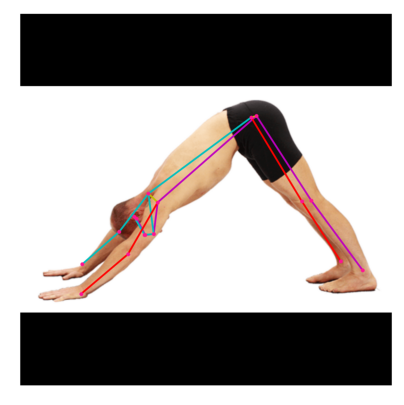

In [52]:
#from yogi.angle_calc import *
#def angle_comp(position,array)
# Load the input image.
img_dir = '../images'
image_path = img_dir + '/' + 'test_downward.png'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image_red(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [58]:
import pandas as pd

# load the numpy array from the JSON file and reshape it to its original form
with open('img_array.json', 'r') as infile:
    img_array_from_json = np.array(json.load(infile))

img_array_from_json

array([[[141, 134, 128],
        [141, 134, 128],
        [142, 135, 129],
        ...,
        [114, 108,  94],
        [114, 107,  97],
        [115, 106,  99]],

       [[141, 134, 126],
        [141, 134, 126],
        [141, 134, 126],
        ...,
        [113, 107,  93],
        [111, 107,  96],
        [113, 106,  98]],

       [[141, 134, 126],
        [141, 134, 126],
        [139, 135, 126],
        ...,
        [108, 109,  95],
        [108, 108,  96],
        [108, 108, 100]],

       ...,

       [[ 80,  71,  64],
        [ 75,  66,  61],
        [ 73,  65,  62],
        ...,
        [ 79,  74,  68],
        [ 81,  73,  70],
        [ 82,  73,  68]],

       [[ 77,  70,  64],
        [ 76,  69,  63],
        [ 73,  64,  59],
        ...,
        [ 78,  73,  67],
        [ 80,  73,  67],
        [ 81,  72,  67]],

       [[ 77,  70,  64],
        [ 75,  68,  62],
        [ 73,  62,  58],
        ...,
        [ 79,  74,  68],
        [ 81,  74,  68],
        [ 81,  72,  67]]

plt.imshow()